# Spectral Map

In [1]:
# import necessary Python packages
import os
import numpy as np
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

## Reference object

In [2]:
img=mpimg.imread('data/layout.jpg')

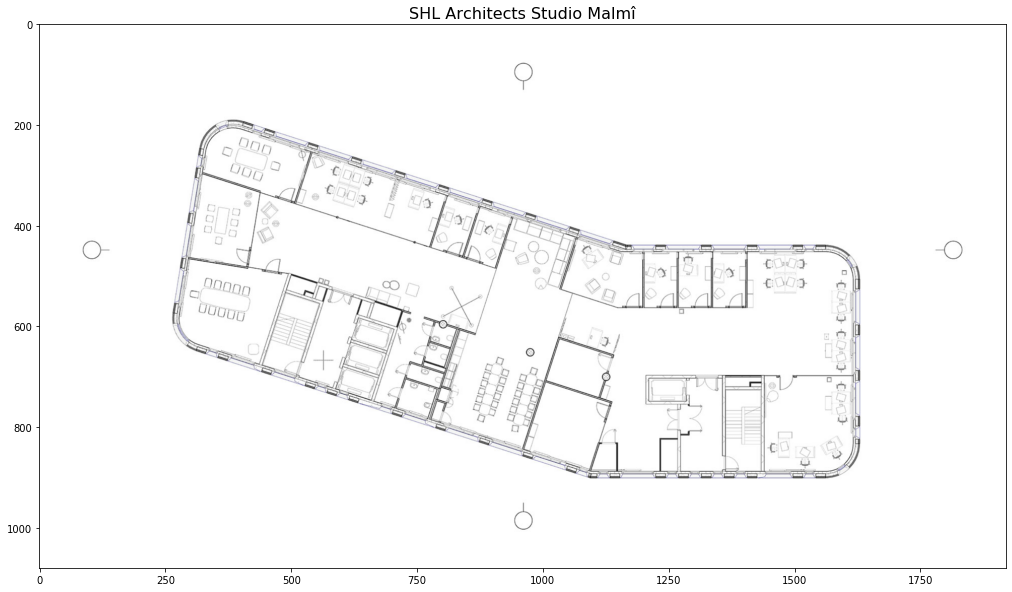

In [3]:
fig = plt.figure(figsize = (30,10))
a = fig.add_subplot(1, 1, 1)
imgplot = plt.imshow(img, interpolation="bilinear")
a.set_title('SHL Architects Studio Malmî', fontsize=16);

## Get structured data

In [4]:
import pandas as pd
# Load data 
rooms = pd.read_csv('data/room_schedule.csv', skiprows=[2], keep_default_na=False)
rooms.columns = rooms.iloc[0]
rooms.drop([0], inplace=True)
rooms['Area'] = rooms['Area'].map(lambda x: x.rstrip(' m²'))

In [5]:
rooms

,Number,Name,Area,Perimeter
1,1,CTO Office,9.52,12794
2,2,Legal Eagle Office,9.51,12786
3,3,PA Office,9.51,12786
4,4,CEO Office,21.62,18879
5,5,HR Office,9.30,12587
6,6,CFO Office,9.25,12565
7,7,Sales Arena,39.79,28112
8,8,Swedese,26.82,21385
9,9,Offecct,25.06,20274
10,10,WC1,2.21,5951


In [7]:
import pandas as pd
# Load data 
doors = pd.read_csv('data/door_schedule.csv', skiprows=[2], keep_default_na=False)
doors.columns = doors.iloc[0]
doors.drop([0], inplace=True)

In [8]:
doors

,Mark,From Room: Number,To Room: Number,Rough Width,Rough Height
1,632296,1,16,1015,2102
2,642739,2,16,1015,2102
3,650548,3,16,1015,2102
4,196335,4,16,1015,2102
5,654502,6,16,1015,2102
6,320281,7,16,970,1680
7,320293,7,16,970,1680
8,655552,8,16,1015,2102
9,652881,9,16,1015,2102
10,542383,10,16,810,1900


In [9]:
doors['From Room: Number'][:-1] = doors['From Room: Number'][:-1].map(lambda k: rooms["Name"][int(k)])

In [10]:
doors['To Room: Number'][:-1] = doors['To Room: Number'][:-1].map(lambda k: rooms["Name"][int(k)])

In [11]:
doors = doors.rename(columns={'From Room: Number': 'From Room', 'To Room: Number': 'To Room', 'Rough Width': 'Width', 'Rough Height': 'Height'})

In [12]:
doors

,Mark,From Room,To Room,Width,Height
1,632296,CTO Office,Open,1015,2102
2,642739,Legal Eagle Office,Open,1015,2102
3,650548,PA Office,Open,1015,2102
4,196335,CEO Office,Open,1015,2102
5,654502,CFO Office,Open,1015,2102
6,320281,Sales Arena,Open,970,1680
7,320293,Sales Arena,Open,970,1680
8,655552,Swedese,Open,1015,2102
9,652881,Offecct,Open,1015,2102
10,542383,WC1,Open,810,1900


## Preprocessing

In [13]:
import seaborn as sns

In [14]:
def plotDataAndCov(data):
    ACov = np.cov(data, rowvar=False, bias=True)
    print('Covariance matrix:\n', ACov)

    fig, ax = plt.subplots(nrows=1, ncols=2)
    fig.set_size_inches(10, 10)

    ax0 = plt.subplot(2, 2, 1)
    
    # Choosing the colors
    cmap = sns.color_palette("GnBu", 10)
    sns.heatmap(ACov, cmap=cmap, vmin=0)

    ax1 = plt.subplot(2, 2, 2)
    
    # data can include the colors
    if data.shape[1]==3:
        c=data[:,2]
    else:
        c="#0A98BE"
    ax1.scatter(data[:,0], data[:,1], c=c, s=40)
    
    # Remove the top and right axes from the data plot
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)

In [15]:
def calculateCovariance(X):
    meanX = np.mean(X, axis = 0)
    lenX = X.shape[0]
    X = X - meanX
    covariance = X.T.dot(X)/lenX
    return covariance

In [16]:
def center(X):
    newX = X - np.mean(X, axis = 0)
    return newX

In [17]:
def standardize(X):
    newX = center(X)/np.std(X, axis = 0)
    return newX

In [18]:
def whiten(X):
    cov = X.T.dot(X)/float(X.shape[0])
    # Calculate the eigenvalues and eigenvectors of the covariance matrix
    eigVals, eigVecs = np.linalg.eig(cov)
    # Apply the eigenvectors to X
    decorrelated = X.dot(eigVecs)
    # Rescale the decorrelated data
    whitened = decorrelated / np.sqrt(eigVals + 1e-5)
    return whitened

### Preprocessing rooms

In [19]:
ra = np.array(rooms['Area']).astype(float)

In [20]:
rp = np.array(rooms['Perimeter']).astype(int)

In [21]:
R = np.array([ra, rp]).T
R.shape

(25, 2)

Covariance matrix:
 [[4.35007358e+03 2.05336376e+06]
 [2.05336376e+06 9.72926609e+08]]


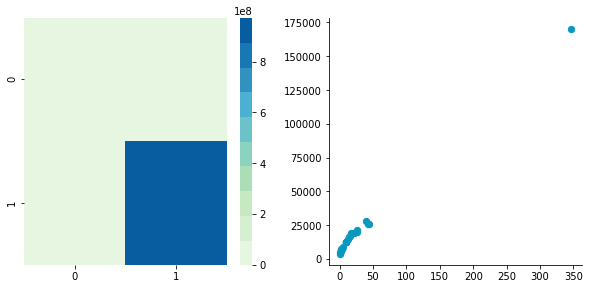

In [22]:
plotDataAndCov(R)
plt.show()
plt.close()

In [23]:
R = center(R)

Covariance matrix:
 [[4.35007358e+03 2.05336376e+06]
 [2.05336376e+06 9.72926609e+08]]


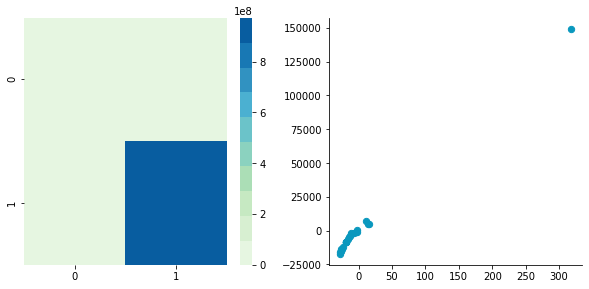

In [24]:
plotDataAndCov(R)
plt.show()
plt.close()

In [25]:
R = standardize((R))

Covariance matrix:
 [[1.         0.99810803]
 [0.99810803 1.        ]]


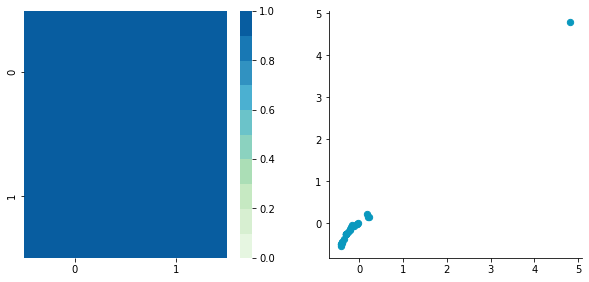

In [26]:
plotDataAndCov(R)
plt.show()
plt.close()

In [27]:
R = whiten(R)

Covariance matrix:
 [[ 9.94742282e-01 -3.24338527e-15]
 [-3.24338527e-15  9.99994995e-01]]


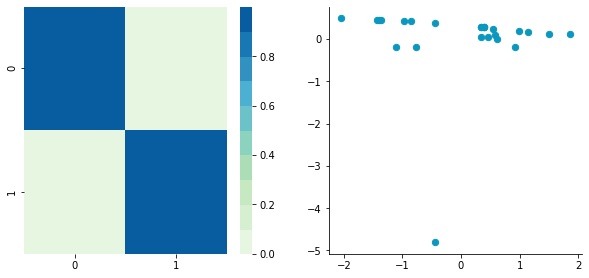

In [28]:
plotDataAndCov(R)
plt.show()
plt.close()

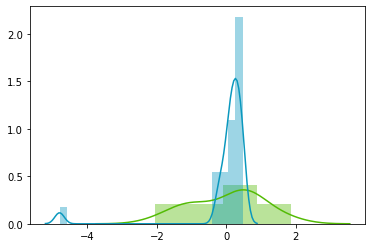

In [29]:
sns.distplot(R[:,0], color="#53BB04")
sns.distplot(R[:,1], color="#0A98BE")
plt.show()
plt.close()

### Preprocessing doors

In [30]:
dw = np.array(doors['Width'][:-1]).astype(int)

In [31]:
dh = np.array(doors['Height'][:-1]).astype(int)

In [32]:
D = np.array([dw, dh]).T
D.shape

(26, 2)

Covariance matrix:
 [[78489.07248521 15016.40236686]
 [15016.40236686 16871.62130178]]


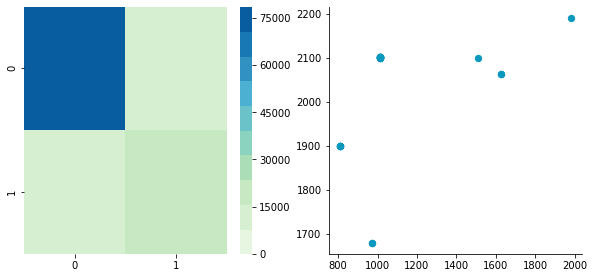

In [33]:
plotDataAndCov(D)
plt.show()
plt.close()

In [34]:
D = center(D)

Covariance matrix:
 [[78489.07248521 15016.40236686]
 [15016.40236686 16871.62130178]]


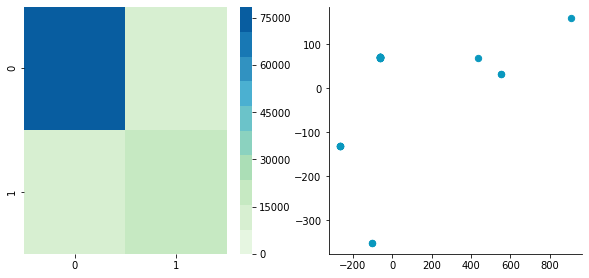

In [35]:
plotDataAndCov(D)
plt.show()
plt.close()

In [36]:
D = standardize((D))

Covariance matrix:
 [[1.         0.41265099]
 [0.41265099 1.        ]]


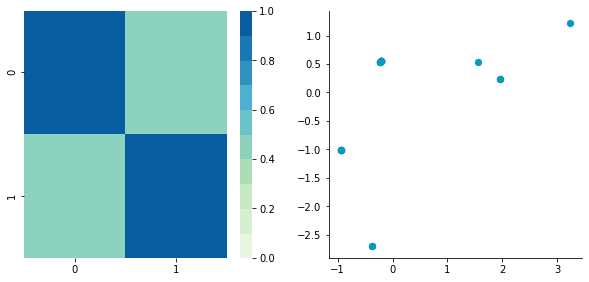

In [37]:
plotDataAndCov(D)
plt.show()
plt.close()

In [38]:
D = whiten(D)

Covariance matrix:
 [[9.99992921e-01 6.98715852e-17]
 [6.98715852e-17 9.99982975e-01]]


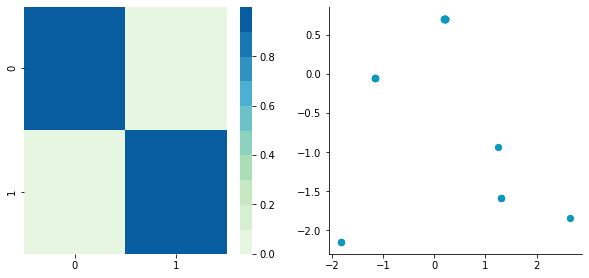

In [39]:
plotDataAndCov(D)
plt.show()
plt.close()

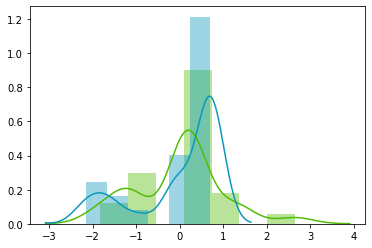

In [40]:
sns.distplot(D[:,0], color="#53BB04")
sns.distplot(D[:,1], color="#0A98BE")
plt.show()
plt.close()

## Graph construction

In [41]:
fr = np.array(doors['From Room'][:-1])
fr.reshape(fr.shape[0], 1).shape

(26, 1)

In [42]:
to = np.array(doors['To Room'][:-1])
to.reshape(to.shape[0], 1).shape

(26, 1)

In [43]:
pairs = np.vstack((fr, to)).T
pairs

array([['CTO Office', 'Open'],
       ['Legal Eagle Office', 'Open'],
       ['PA Office', 'Open'],
       ['CEO Office', 'Open'],
       ['CFO Office', 'Open'],
       ['Sales Arena', 'Open'],
       ['Sales Arena', 'Open'],
       ['Swedese', 'Open'],
       ['Offecct', 'Open'],
       ['WC1', 'Open'],
       ['WC3', 'Open'],
       ['VR Room', 'Open'],
       ['Open', 'HR Office'],
       ['Open', 'WC2'],
       ['Open', 'WC4'],
       ['Open', 'Copy'],
       ['Open', 'EFG'],
       ['Open', 'Storage'],
       ['Marketing', 'Open'],
       ['Recovery', 'Open'],
       ['Entrance1', 'Open'],
       ['Entrance1', 'Stairs1'],
       ['Entrance2', 'Open'],
       ['Entrance2', 'Stairs2'],
       ['Entrance2', 'Revision'],
       ['Revision', 'Open']], dtype=object)

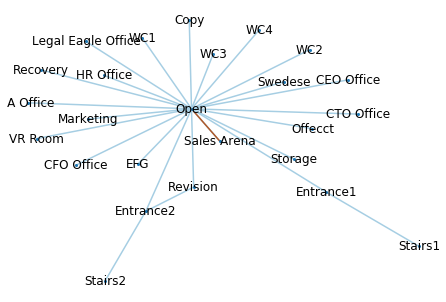

In [44]:
import networkx as nx
import warnings
warnings.filterwarnings("ignore")
 
# Create a networkx graph object
G = nx.MultiGraph() 
 
# Add edges to to the graph object
# Each tuple represents an edge between two nodes
G.add_edges_from(pairs)
c = np.array(G.edges).T[2].astype(int)
my_pos = nx.spring_layout(G, seed = 56)
# Draw the resulting graph
nx.draw(G, pos=my_pos, with_labels=True, edge_color=c, width=1.5, node_size=4, edge_cmap=plt.cm.Paired)

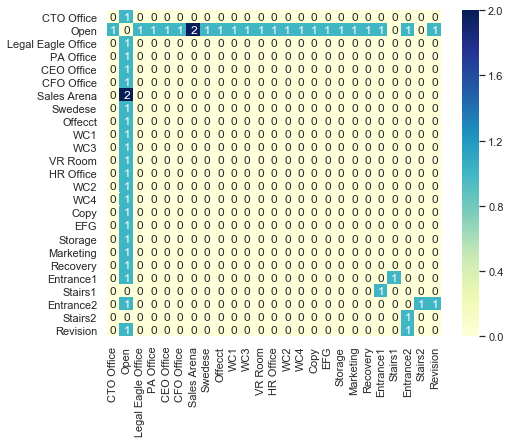

In [45]:
A = nx.to_numpy_matrix(G)
plt.figure(figsize=(7.5,6))
sns.set()
sns.heatmap(A, cmap="YlGnBu", annot=True, xticklabels=G.nodes, yticklabels=G.nodes);

In [46]:
G.nodes(data=True)

NodeDataView({'CTO Office': {}, 'Open': {}, 'Legal Eagle Office': {}, 'PA Office': {}, 'CEO Office': {}, 'CFO Office': {}, 'Sales Arena': {}, 'Swedese': {}, 'Offecct': {}, 'WC1': {}, 'WC3': {}, 'VR Room': {}, 'HR Office': {}, 'WC2': {}, 'WC4': {}, 'Copy': {}, 'EFG': {}, 'Storage': {}, 'Marketing': {}, 'Recovery': {}, 'Entrance1': {}, 'Stairs1': {}, 'Entrance2': {}, 'Stairs2': {}, 'Revision': {}})

In [47]:
G.edges(data=True)

MultiEdgeDataView([('CTO Office', 'Open', {}), ('Open', 'Legal Eagle Office', {}), ('Open', 'PA Office', {}), ('Open', 'CEO Office', {}), ('Open', 'CFO Office', {}), ('Open', 'Sales Arena', {}), ('Open', 'Sales Arena', {}), ('Open', 'Swedese', {}), ('Open', 'Offecct', {}), ('Open', 'WC1', {}), ('Open', 'WC3', {}), ('Open', 'VR Room', {}), ('Open', 'HR Office', {}), ('Open', 'WC2', {}), ('Open', 'WC4', {}), ('Open', 'Copy', {}), ('Open', 'EFG', {}), ('Open', 'Storage', {}), ('Open', 'Marketing', {}), ('Open', 'Recovery', {}), ('Open', 'Entrance1', {}), ('Open', 'Entrance2', {}), ('Open', 'Revision', {}), ('Entrance1', 'Stairs1', {}), ('Entrance2', 'Stairs2', {}), ('Entrance2', 'Revision', {})])

## Embed Attributes

In [48]:
room_vector = []
area = 0.0
perimeter = 0
nx.set_node_attributes(G, room_vector, 'vector')
nx.set_node_attributes(G, area, 'area')
nx.set_node_attributes(G, perimeter, 'perimeter')

In [49]:
G.nodes.data()

NodeDataView({'CTO Office': {'vector': [], 'area': 0.0, 'perimeter': 0}, 'Open': {'vector': [], 'area': 0.0, 'perimeter': 0}, 'Legal Eagle Office': {'vector': [], 'area': 0.0, 'perimeter': 0}, 'PA Office': {'vector': [], 'area': 0.0, 'perimeter': 0}, 'CEO Office': {'vector': [], 'area': 0.0, 'perimeter': 0}, 'CFO Office': {'vector': [], 'area': 0.0, 'perimeter': 0}, 'Sales Arena': {'vector': [], 'area': 0.0, 'perimeter': 0}, 'Swedese': {'vector': [], 'area': 0.0, 'perimeter': 0}, 'Offecct': {'vector': [], 'area': 0.0, 'perimeter': 0}, 'WC1': {'vector': [], 'area': 0.0, 'perimeter': 0}, 'WC3': {'vector': [], 'area': 0.0, 'perimeter': 0}, 'VR Room': {'vector': [], 'area': 0.0, 'perimeter': 0}, 'HR Office': {'vector': [], 'area': 0.0, 'perimeter': 0}, 'WC2': {'vector': [], 'area': 0.0, 'perimeter': 0}, 'WC4': {'vector': [], 'area': 0.0, 'perimeter': 0}, 'Copy': {'vector': [], 'area': 0.0, 'perimeter': 0}, 'EFG': {'vector': [], 'area': 0.0, 'perimeter': 0}, 'Storage': {'vector': [], 'area'

In [50]:
for i, node in enumerate(rooms['Name']):
    G.nodes[node]['vector'] = R[i]
    G.nodes[node]['area'] = ra[i]
    G.nodes[node]['perimeter'] = rp[i]

In [51]:
G.nodes.data()

NodeDataView({'CTO Office': {'vector': array([0.39616225, 0.27454983]), 'area': 9.52, 'perimeter': 12794}, 'Open': {'vector': array([-0.44475996, -4.80067892]), 'area': 345.81, 'perimeter': 170216}, 'Legal Eagle Office': {'vector': array([0.39446208, 0.27475397]), 'area': 9.51, 'perimeter': 12786}, 'PA Office': {'vector': array([0.39446208, 0.27475397]), 'area': 9.51, 'perimeter': 12786}, 'CEO Office': {'vector': array([0.58465247, 0.08518988]), 'area': 21.62, 'perimeter': 18879}, 'CFO Office': {'vector': array([0.34350021, 0.28027021]), 'area': 9.25, 'perimeter': 12565}, 'Sales Arena': {'vector': array([ 0.91731101, -0.20069369]), 'area': 39.79, 'perimeter': 28112}, 'Swedese': {'vector': array([0.60897589, 0.00556079]), 'area': 26.82, 'perimeter': 21385}, 'Offecct': {'vector': array([0.4641296 , 0.03672705]), 'area': 25.06, 'perimeter': 20274}, 'WC1': {'vector': array([-1.36387001,  0.43973645]), 'area': 2.21, 'perimeter': 5951}, 'WC3': {'vector': array([-0.85119974,  0.41648648]), 'a

In [52]:
door_vector = []
width = 0
height = 0
nx.set_edge_attributes(G, door_vector, 'vector')
nx.set_edge_attributes(G, width, 'width')
nx.set_edge_attributes(G, height, 'height')

In [53]:
G.edges.data()

MultiEdgeDataView([('CTO Office', 'Open', {'vector': [], 'width': 0, 'height': 0}), ('Open', 'Legal Eagle Office', {'vector': [], 'width': 0, 'height': 0}), ('Open', 'PA Office', {'vector': [], 'width': 0, 'height': 0}), ('Open', 'CEO Office', {'vector': [], 'width': 0, 'height': 0}), ('Open', 'CFO Office', {'vector': [], 'width': 0, 'height': 0}), ('Open', 'Sales Arena', {'vector': [], 'width': 0, 'height': 0}), ('Open', 'Sales Arena', {'vector': [], 'width': 0, 'height': 0}), ('Open', 'Swedese', {'vector': [], 'width': 0, 'height': 0}), ('Open', 'Offecct', {'vector': [], 'width': 0, 'height': 0}), ('Open', 'WC1', {'vector': [], 'width': 0, 'height': 0}), ('Open', 'WC3', {'vector': [], 'width': 0, 'height': 0}), ('Open', 'VR Room', {'vector': [], 'width': 0, 'height': 0}), ('Open', 'HR Office', {'vector': [], 'width': 0, 'height': 0}), ('Open', 'WC2', {'vector': [], 'width': 0, 'height': 0}), ('Open', 'WC4', {'vector': [], 'width': 0, 'height': 0}), ('Open', 'Copy', {'vector': [], 'wi